In [7]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

In [8]:
def run(t_end, changes = {}, *, dt=0.001, path:Path=None):
    #print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    #params = ParameterSet("structure.json")
    params = ParameterSet("ExtendedV1.json")
    params.batch_update(changes)
    #params.J.print_matrix()
    #params.J_ampa.print_matrix()
    #print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')
        params.saveHtml(path / 'params.html',keys = [])

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    # gen = np.random.Generator(np.random.PCG64(123))
    gen = None
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    #print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

In [9]:
new_params = {"sst1.I_back.dc": 0.25,"sst2.I_back.dc": 0.25,
                "vip1.I_back.type": "sin", "vip1.I_back.amplitude": 0.1, 
                "vip1.I_back.frequency": 4, "vip2.I_back.type": "sin", 
                "vip2.I_back.amplitude": 0.1, "vip2.I_back.frequency": 4,
                "exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}
shut_off_exc_theta = {"exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}

AMPA_increase = {"J_ampa.exc1.exc1":3.8,"J_ampa.exc2.exc2":3.8,
                 "J_ampa.exc1.exc2":1.75,"J_ampa.exc2.exc1":1.75,
                 "J_ampa.pv.exc1":3.2,"J_ampa.pv.exc2":3.2}
Increase_sst = {"sst1.I_back.dc": 0.2,"sst2.I_back.dc": 0.2 }

SmallCircuit={"J.exc1.sst1": 0, "J.exc2.sst2": 0,} # only E1,E2, pv
E_and_I = {"J.exc1.exc2":0, "J.exc1.sst1": 0, "J.pv.exc2":0,
           "J_ampa.exc1.exc2":0, "J_ampa.pv.exc2":0, "exc1.I_back.amplitude":0}

shut_off_NMDA = {"J.exc1.exc1":0 ,"J.pv.exc1":0} 
input = {"exc1.I_ext.height":0, "exc1.I_back.dc":2.5, "pv.I_back.dc":0.5 }


{}


C:\Users\palavia\AppData\Local\Temp\ipykernel_14976\1394830663.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='ExtendedV1.json' mode='r' encoding='cp1252'>
  params = ParameterSet("ExtendedV1.json")
c:\Users\palavia\neural-simulation\src\param.py:69: ResourceWarning: unclosed file <_io.TextIOWrapper name='structure.json' mode='r' encoding='cp1252'>
  base = ParameterSet(base_file).__flat_json__()


KeyboardInterrupt: 

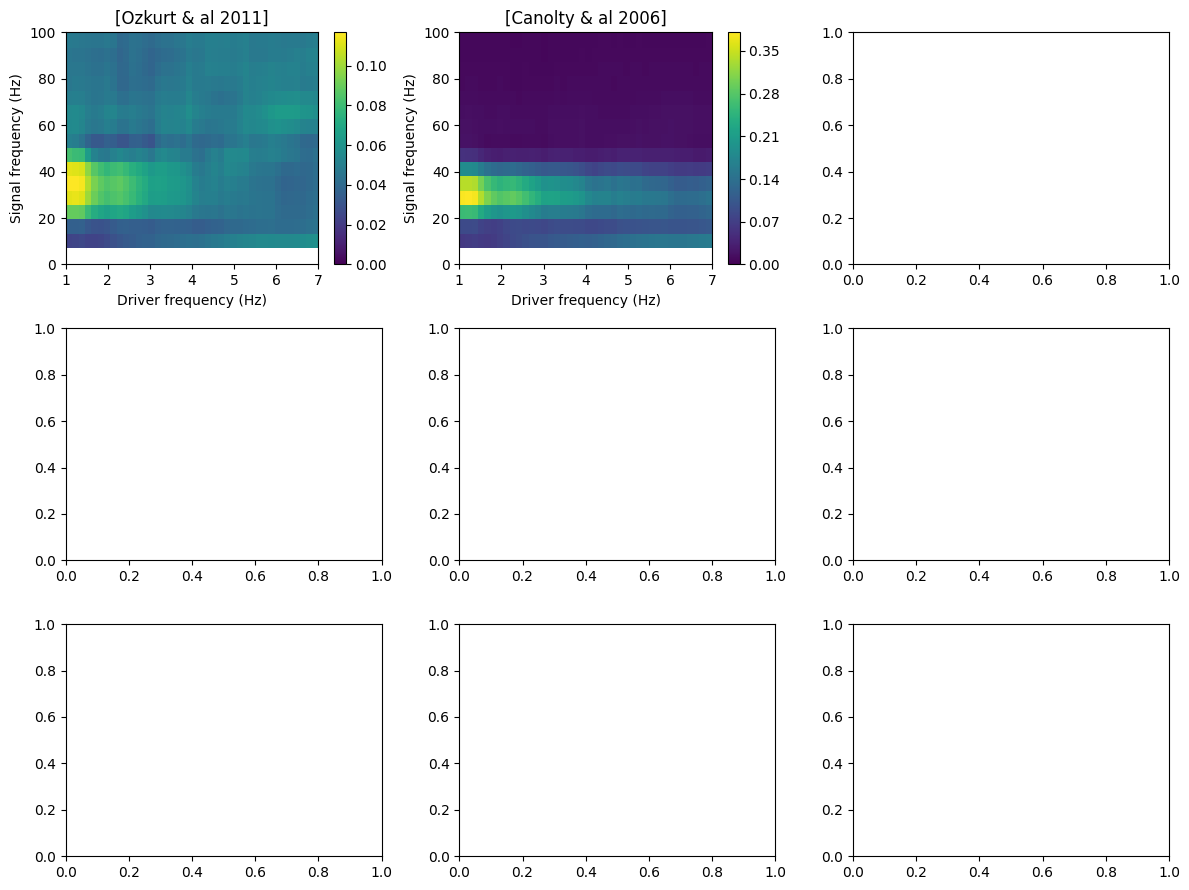

In [10]:
#experiments = [{},{"sst1.opto":0.5, "sst2.opto":0.5}]# incresing input to both E populations
#experiments = [{"J.exc1.sst1":-0.2, "J.exc2.sst2":-0.2}, {"J.exc1.sst1":-0.3, "J.exc2.sst2":-0.3}, {"J.exc1.sst1":-0.4, "J.exc2.sst2":-0.4}]
experiments=[{}]
if __name__ == '__main__':
    exp = 'slowloop'
    for experiment in experiments:
        print(experiment)
        dt = datetime.now()
        folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/{dt.strftime("%H%M%S")}')
        #folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/highampa_theta')
        folder.mkdir(parents=True)
        t, res = run(10, changes = experiment , dt=0.001, path=folder)
        #exc1_r = np.array([x.exc1.r for x in res])
        plots = [
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg'),
            Plot(['exc2.r'], t_start=0, t_end=10, title='Exc 2 Firing Rate', file=folder / 'r2.svg'),
            Plot(['pv.r'],   t_start=0, t_end=10, title='PV Firing Rate',    file=folder / 'pv.svg'),
            Plot(['sst1.r'], t_start=0, t_end=10, title='SST 1 Firing Rate', file=folder / 's1.svg'),
            Plot(['sst2.r'], t_start=0, t_end=10, title='SST 2 Firing Rate', file=folder / 's2.svg'),
            Plot(['vip1.r'], t_start=0, t_end=10, title='VIP 1 Firing Rate', file=folder / 'v1.svg'),
            Plot(['vip2.r'], t_start=0, t_end=10, title='VIP 2 Firing Rate', file=folder / 'v2.svg'),
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 PAC', file=folder / 'pac.svg',plot_type= "pac"),
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 fft', file=folder / 'fft.svg',plot_type= "fft"),
            #Plot(['exc1.r'], t_start=2, t_end=3, title='Exc 1 Firing Rate', file=folder / 'r1-before.svg'),
            # Plot(['exc1.r'], t_start=5, t_end=6, title='Exc 1 Firing Rate', file=f'{folder}/r1-during.png'),
            # Plot(['exc1.r'], t_start=7, t_end=8, title='Exc 1 Firing Rate', file=f'{folder}/r1-after.png'),
            # Plot(['exc1.r','exc2.r','pv.r'], t_start=3, t_end=7, title='Exc 1, 2, PV Firing Rate', file=f'{folder}/r1-r2.png'),
        ]
        for p in plots:
            if p.plot_type == "fft":
                p(t,res,max_fq = 50)
            else:
                p(t,res)
        plots_ref = [p.file.name for p in plots]
        plots_ref = [f'<div class="res-img"><img src="{p}"/></div>' for p in plots_ref]
        plots_ref = '\n'.join(plots_ref)

        html = folder / 'results.html'
        html.write_text(f'''<html>
    <head>
        <title> Summary </title>
        <style>
        .images {{display: flex; flex-wrap: wrap;}}
        .res-img {{}}
        </style>
    </head>
    <body>
    <section id="inputs">
        <iframe src="params.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
        <iframe src="params_delta.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
    </section>
    <section id="results">
        <div class="images">{plots_ref}</div>
    </section>
    </body>
    </html>''')

In [15]:
I = np.linspace(0.3,1.75,31)
freq= []
pow = []
pow_gamma = []
for i in I:
    print(i)
    experiment = {"exc1.I_back.dc": i, "exc2.I_back.dc": i}
    f=[]
    p=[]
    p_g = []
    for j in range(10):
        t, res = run(10, changes = experiment , dt=0.001, path=None)
        obj = Plot(['exc1.r'], t_start=0.5, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg')
        max_f, max_fp, pow_g = obj.max_gamma_power(t, res)
        print(max_f,max_fp)
        f.append(max_f)
        p.append(max_fp)
        p_g.append(pow_g)
    freq.append(sum(f)/len(f))
    pow.append(sum(p)/len(p))
    pow_gamma.append(sum(p_g)/len(p_g))

0.3


C:\Users\palavia\AppData\Local\Temp\ipykernel_14976\1394830663.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='ExtendedV1.json' mode='r' encoding='cp1252'>
  params = ParameterSet("ExtendedV1.json")


26.20776760341017 7.148318446308293e-05
28.523313335438377 8.400680506210773e-05
37.25923586990843 7.464356286157207e-05
27.47079254815283 7.39885743331343e-05
31.78612777602358 7.141031981108003e-05
28.944321650352595 7.176556980706472e-05
31.99663193348069 6.981601316650471e-05
34.733185980423116 7.078961354143321e-05
31.470371539837913 6.814885889000256e-05
28.733817492895486 8.662166338889697e-05
0.34833333333333333
25.892011367224505 0.0004417629970596199
31.049363224923695 0.0004086861427092735
24.628986422481844 0.0004480621799139101
33.04915272076624 0.00041317509291893324
22.734449005367857 0.0004323949288636166
31.259867382380804 0.00042403774860583183
30.94411114619514 0.000441507706279955
25.471003052310284 0.00037639207203170175
26.523523839595835 0.00047438716232976193
32.62814440585202 0.0004301324012222875
0.39666666666666667
24.839490579938957 0.11764269807934898
24.207978107567627 0.09642461537479344
26.102515524681614 0.11308593356738107
23.365961477739187 0.15296726

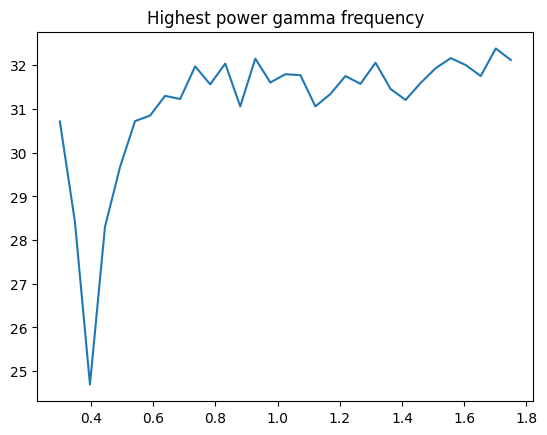

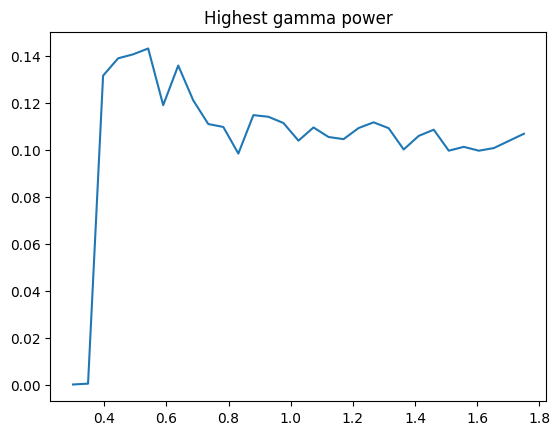

In [16]:
plt.plot(I,freq)
plt.title("Highest power gamma frequency")
plt.show()
plt.plot(I,pow)
plt.title("Highest gamma power")
plt.show()

In [ ]:

I = np.linspace(0.3,1.75,11)
freq= []
pow = []
pow_gamma = []
for i in I:
    print(i)
    experiment = {"exc1.I_back.dc": i, "exc2.I_back.dc": i}
    f=[]
    p=[]
    p_g = []
    for j in range(1):
        t, res = run(10, changes = experiment , dt=0.001, path=None)
        obj = Plot(['exc1.r'], t_start=0.5, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg')
        max_f, max_fp, pow_g = obj.max_gamma_power(t, res)
        print(max_f,max_fp)
        f.append(max_f)
        p.append(max_fp)
        p_g.append(pow_g)
    freq.append(sum(f)/len(f))
    pow.append(sum(p)/len(p))
    pow_gamma.append(sum(p_g)/len(p_g))
        

0.3


C:\Users\palavia\AppData\Local\Temp\ipykernel_31892\1394830663.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='ExtendedV1.json' mode='r' encoding='cp1252'>
  params = ParameterSet("ExtendedV1.json")


29.04957372908115 8.082339340685284e-05
0.44499999999999995
27.9970529417956 0.14914283050469682
0.59
30.52310283128092 0.1358195526027282
0.7349999999999999
29.996842437638147 0.1169955825193563
0.8799999999999999
31.15461530365225 0.11842914804766917
1.025
31.99663193348069 0.10024828917984076
1.17
32.733396484580574 0.12022137280864599
1.315
30.31259867382381 0.09688700355328281
1.46
33.996421429323235 0.10107602401252268
1.605
29.89159035890959 0.10471135754586898
1.75
30.52310283128092 0.13561390212884852


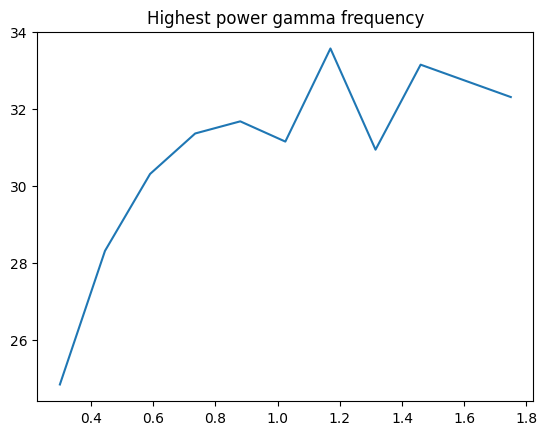

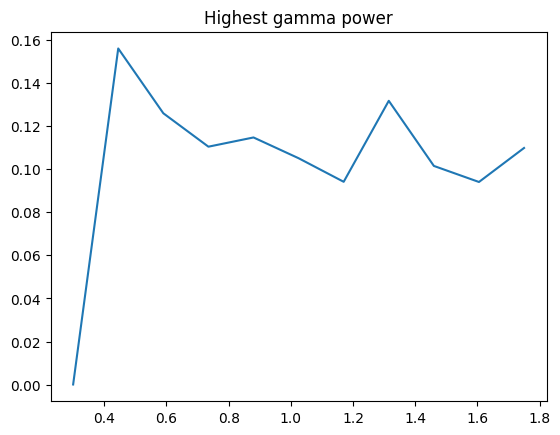

In [8]:
plt.plot(I,freq)
plt.title("Highest power gamma frequency")
plt.show()
plt.plot(I,pow)
plt.title("Highest gamma power")
plt.show()

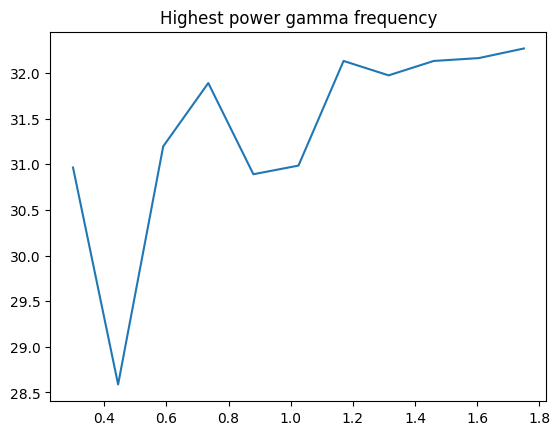

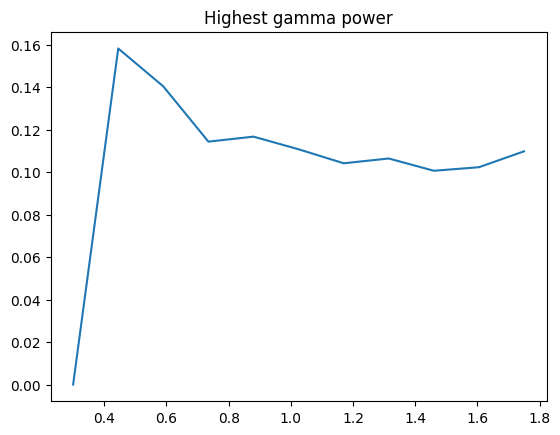

In [5]:
# this is the result with the first 0.5 s thrown away
plt.plot(I,freq)
plt.title("Highest power gamma frequency")
plt.show()
plt.plot(I,pow)
plt.title("Highest gamma power")
plt.show()


In [12]:
# slowly closing the loop
J = [0, 0.1 ]
for j in J:
    closed_loop = {"J.exc1.sst1":-j, "J.exc2.sst2":-j}
    I = np.linspace(0.3,1.75,11)
    freq =[]
    pow = []
    print(j)
    for i in I:
        #print(i)
        experiment = {"exc1.I_back.dc": i, "exc2.I_back.dc": i}
        experiment.update(closed_loop)
        f=[]
        p=[]
        for k in range(30):
            t, res = run(10, changes = experiment , dt=0.001, path=None)
            obj = Plot(['exc1.r'], t_start=0.5, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg')
            max_f, max_fp = obj.max_gamma_power(t, res)
            #print(max_f,max_fp)
            f.append(max_f)
            p.append(max_fp)
        freq.append(sum(f)/len(f))
        pow.append(sum(p)/len(p))
    plt.plot(I,freq)
    plt.title("Highest power gamma frequency")
    plt.show()
    plt.plot(I,pow)
    plt.title("Highest gamma power")
    plt.show()

0


C:\Users\palavia\AppData\Local\Temp\ipykernel_9376\1394830663.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='ExtendedV1.json' mode='r' encoding='cp1252'>
  params = ParameterSet("ExtendedV1.json")


KeyboardInterrupt: 